<h1><center> 
    Enhancing Glioma Grading: Integrating Genomic and Clinical Features with Deep learning
</center></h1>

<h2>Course: CptS 534</h2>

##### Jingjing Nie: 11742013, School of Electrical Engineering and Computer Science
##### Wooyoung Kim: 11808206, Department of Mathematics and Statistics
##### Xinyue Wu: 11809269, Department of Sociology

### 1. Download dataset from UCI Machine learning Respository
###### (See detail in https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset)

In [16]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# data (as pandas dataframes) 
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 
  
# metadata 
print(glioma_grading_clinical_and_mutation_features.metadata) 
  
# variable information 
print(glioma_grading_clinical_and_mutation_features.variables) 


{'uci_id': 759, 'name': 'Glioma Grading Clinical and Mutation Features', 'repository_url': 'https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/759/data.csv', 'abstract': 'Gliomas are the most common primary tumors of the brain. They can be graded as LGG (Lower-Grade Glioma) or GBM (Glioblastoma Multiforme) depending on the histological/imaging criteria. Clinical and molecular/mutation factors are also very crucial for the grading process. Molecular tests are expensive to help accurately diagnose glioma patients.    In this dataset, the most frequently mutated 20 genes and 3 clinical features are considered from TCGA-LGG and TCGA-GBM brain glioma projects.  The prediction task is to determine whether a patient is LGG or GBM with a given clinical and molecular/mutation features. The main objective is to find the optimal subset of mutation genes and clinical features for the glioma grading 

### 2. import Python liberaries

In [17]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

### 3. Split the dataset

In [18]:
# Convert them to numpy arrays and replace race info
X_numpy = X.to_numpy()
y_numpy = y.to_numpy()

my_dict = {'white': 0, 'black or african american': 1, 'asian': 2, 'american indian or alaska native':3}
for element in X_numpy:
    if element[2]=='white':
        element[2] = 0
    elif element[2]=='black or african american':
        element[2] = 1
    elif element[2]== 'asian':
        element[2] = 2
    elif element[2]== 'american indian or alaska native':
        element[2] = 3
X_numpy = X_numpy.astype(float)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_numpy, dtype=torch.float)
y_tensor = torch.tensor(y_numpy, dtype=torch.long)
y_tensor = y_tensor.squeeze()

# Create a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)
# Hyper-parameters 
input_size = 23
hidden_size = 10
num_classes = 2
learning_rate = 0.001
num_epochs = 10
batch_size = 100
# Define the sizes for training and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


### 4. Define the model, loss function, and optimization algorithm (optimizer)

In [4]:

# Device configuration: check if there is a configured GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define a model using class NeuralNet()
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimization algorithm (optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


### 5. Train and test the model

Epoch [1/10], Loss: 0.6043
Accuracy on test set: 88.10%
Accuracy of the network on the training inputs: 82.11624441132638 %
Epoch [2/10], Loss: 0.5755
Accuracy on test set: 87.50%
Accuracy of the network on the training inputs: 82.11624441132638 %
Epoch [3/10], Loss: 0.6029
Accuracy on test set: 88.69%
Accuracy of the network on the training inputs: 83.15946348733235 %
Epoch [4/10], Loss: 0.5717
Accuracy on test set: 89.29%
Accuracy of the network on the training inputs: 84.2026825633383 %
Epoch [5/10], Loss: 0.5842
Accuracy on test set: 86.90%
Accuracy of the network on the training inputs: 82.41430700447094 %
Epoch [6/10], Loss: 0.5533
Accuracy on test set: 87.50%
Accuracy of the network on the training inputs: 83.01043219076006 %
Epoch [7/10], Loss: 0.5327
Accuracy on test set: 88.69%
Accuracy of the network on the training inputs: 83.60655737704919 %
Epoch [8/10], Loss: 0.5514
Accuracy on test set: 88.69%
Accuracy of the network on the training inputs: 84.35171385991057 %
Epoch [9/

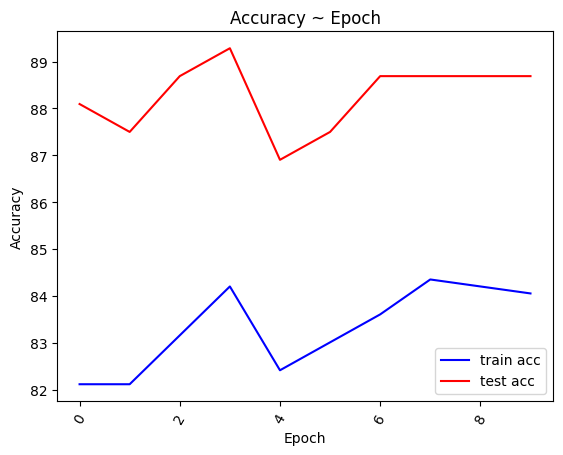

In [8]:
# Train the model
total_step = len(train_loader)
test_acc_list, train_acc_list = [], []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        

    # Print average loss at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluation on Test Set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        print(f"Accuracy on test set: {(100 * correct / total):.2f}%")
        test_acc_list.append(100 * correct / total)
    with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
            print('Accuracy of the network on the training inputs: {} %'.format(100 * correct / total))
            train_acc_list.append(100 * correct / total)
plt.plot(train_acc_list, '-b', label='train acc')
plt.plot(test_acc_list, '-r', label='test acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Accuracy ~ Epoch')
# plt.savefig('assets/accr_{}.png'.format(cfg_idx))
plt.show()
        

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=23, stratify=y_numpy)

/home/yougu/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yougu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Logistic Regression
ACC: 0.8690476190476191


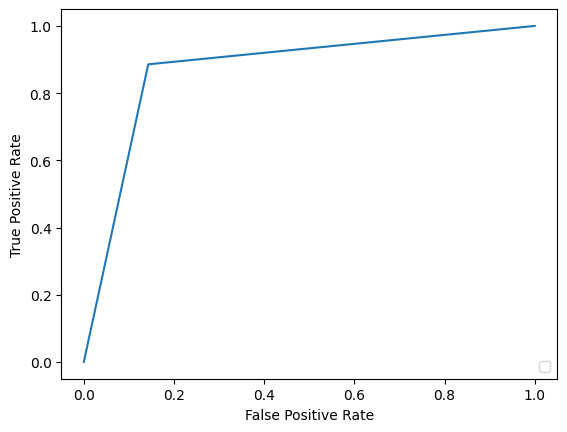

In [29]:
reg_model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = reg_model.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Logistic Regression")
print(f"ACC: {acc}")
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

/home/yougu/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Support Vector Machines
ACC: 0.7440476190476191


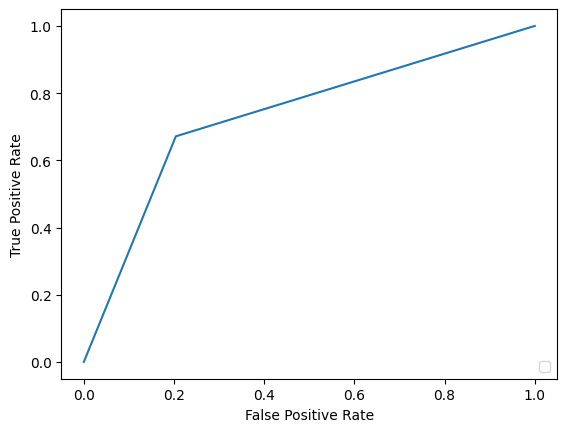

In [30]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ACC = accuracy_score(y_test,y_pred)
print("Support Vector Machines")
print(f"ACC: {ACC}")
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()